In [1]:
# enable autoreload
%load_ext autoreload
%autoreload 2

# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans

#others
from xgboost import XGBRegressor
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import time
import xarray as xr
import sherpa

# Variables from config file
from config import BASE_DIR, FILE_NAMES, LABELS, ATTRIBUTES, BEST_MODEL_COLUMNS


In [5]:
print(f"{LABELS=}")

LABELS=['air2m', 'air1000_500', 'hgt500', 'hgt1000', 'omega500', 'pottemp1000-500', 'pottemp1000-850', 'pr_wtr', 'shum-uwnd-700', 'shum-uwnd-925', 'shum-vwnd-700', 'shum-vwnd-950', 'shum700', 'shum925', 'skt', 'slp']


# Explore:
<list>
    <li>Inclusion of altitude information</li>
    <li>Inclusion of seasonality indicator (dry/wet)</li>
    <li>Linear interpolation</li>
    <li>Use 6 reanalysis observations</li>
</list>
<hr>

<b><h3>The models in this file uses parameters that were obtained through hyperparameter tuning by external python scripts.</h3></b>
<hr>

In [2]:
# load datasets
df_train = pd.read_csv(f"{BASE_DIR}/train.csv")
df_valid = pd.read_csv(f"{BASE_DIR}/valid.csv")
df_test = pd.read_csv(f"{BASE_DIR}/test.csv")

# Nov-Apr = "wet", May-Oct = "dry"
wet = [11, 12, 1, 2, 3, 4]
dry = [5, 6, 7, 8, 9, 10]
df_train['season_dry'] = df_train.apply(lambda row: 1 if row.month in dry else 0, axis=1)
df_train['season_wet'] = df_train.apply(lambda row: 1 if row.month in wet else 0, axis=1)

df_valid['season_dry'] = df_valid.apply(lambda row: 1 if row.month in dry else 0, axis=1)
df_valid['season_wet'] = df_valid.apply(lambda row: 1 if row.month in wet else 0, axis=1)

df_test['season_dry'] = df_test.apply(lambda row: 1 if row.month in dry else 0, axis=1)
df_test['season_wet'] = df_test.apply(lambda row: 1 if row.month in wet else 0, axis=1)

In [5]:
line = ""
for label in df_train.columns:
    line += str(label) + " "
print(line)

skn year month data_in name lat lon elevation Observer Status2010 NumMos MinYear MaxYear i100_air2m i100_air1000_500 i100_hgt500 i100_hgt1000 i100_omega500 i100_pottemp1000-500 i100_pottemp1000-850 i100_pr_wtr i100_shum-uwnd-700 i100_shum-uwnd-925 i100_shum-vwnd-700 i100_shum-vwnd-950 i100_shum700 i100_shum925 i100_skt i100_slp air2m air1000_500 hgt500 hgt1000 omega500 pottemp1000-500 pottemp1000-850 pr_wtr shum-uwnd-700 shum-uwnd-925 shum-vwnd-700 shum-vwnd-950 shum700 shum925 skt slp i50_air2m i50_air1000_500 i50_hgt500 i50_hgt1000 i50_omega500 i50_pottemp1000-500 i50_pottemp1000-850 i50_pr_wtr i50_shum-uwnd-700 i50_shum-uwnd-925 i50_shum-vwnd-700 i50_shum-vwnd-950 i50_shum700 i50_shum925 i50_skt i50_slp air2m_0 air2m_1 air2m_2 air2m_3 air2m_4 air2m_5 air1000_500_0 air1000_500_1 air1000_500_2 air1000_500_3 air1000_500_4 air1000_500_5 hgt500_0 hgt500_1 hgt500_2 hgt500_3 hgt500_4 hgt500_5 hgt1000_0 hgt1000_1 hgt1000_2 hgt1000_3 hgt1000_4 hgt1000_5 omega500_0 omega500_1 omega500_2 omega

In [5]:
base_columns = ["data_in", "lat", "lon", "elevation"]

# Q1. Does the inclusion of altitude information help the models perform better?

In [6]:
columns = (base_columns + LABELS)
print(f"labels to use: {columns}")

labels to use: ['data_in', 'lat', 'lon', 'elevation', 'air2m', 'air1000_500', 'hgt500', 'hgt1000', 'omega500', 'pottemp1000-500', 'pottemp1000-850', 'pr_wtr', 'shum-uwnd-700', 'shum-uwnd-925', 'shum-vwnd-700', 'shum-vwnd-950', 'shum700', 'shum925', 'skt', 'slp']


## 1.1 Train models without elevation

In [8]:
Xtrain = np.array(df_train[columns].drop(labels=["data_in", "elevation"], axis=1))
Ytrain = np.array(df_train["data_in"])

Xvalid = np.array(df_valid[columns].drop(labels=["data_in", "elevation"], axis=1))
Yvalid = np.array(df_valid["data_in"])

Xtest = np.array(df_test[columns].drop(labels=["data_in", "elevation"], axis=1))
Ytest = np.array(df_test["data_in"])

In [9]:
# hyperparameters acquired in external experiment
linear_regression = LinearRegression()
random_forest = RandomForestRegressor(
    n_estimators=270,
    max_depth=None,
    min_samples_split=3,
    n_jobs=-1,
    verbose=False,
)

gradient_boost = GradientBoostingRegressor(
    n_estimators=240, 
    learning_rate=0.1,
    max_depth=7,
    min_samples_split=4,
    verbose=False
)

xgboost = XGBRegressor(
    n_estimators=210,
    learning_rate=0.1,
    max_depth=9,
    verbosity=0
)

linear_regression.fit(Xtrain, Ytrain)
random_forest.fit(Xtrain, Ytrain)
gradient_boost.fit(Xtrain, Ytrain)
xgboost.fit(Xtrain, Ytrain)

mse_wout_elev = [
    mean_squared_error(Ytest, linear_regression.predict(Xtest)),
    mean_squared_error(Ytest, random_forest.predict(Xtest)),
    mean_squared_error(Ytest, gradient_boost.predict(Xtest)),
    mean_squared_error(Ytest, xgboost.predict(Xtest)),
]

print(f"{mse_wout_elev=}")

mse_wout_elev=[33.86869309419888, 17.52538845081093, 17.743511141294324, 16.69652236267537]


## 1.2 Train Models with elevation data 

In [7]:
Xtrain = np.array(df_train[columns].drop(labels=["data_in"], axis=1))
Ytrain = np.array(df_train["data_in"])

Xvalid = np.array(df_valid[columns].drop(labels=["data_in"], axis=1))
Yvalid = np.array(df_valid["data_in"])

Xtest = np.array(df_test[columns].drop(labels=["data_in"], axis=1))
Ytest = np.array(df_test["data_in"])

In [8]:
# hyperparameters are fine tuned for this dataset
linear_regression = LinearRegression()
random_forest = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=5,
    n_jobs=-1,
    verbose=False,
)

gradient_boost = GradientBoostingRegressor(
    n_estimators=240, 
    learning_rate=0.05,
    max_depth=7,
    min_samples_split=7,
    verbose=False
)

xgboost = XGBRegressor(
    n_estimators=250,
    learning_rate=0.05,
    max_depth=8,
    verbosity=0
)

linear_regression.fit(Xtrain, Ytrain)
random_forest.fit(Xtrain, Ytrain)
gradient_boost.fit(Xtrain, Ytrain)
xgboost.fit(Xtrain, Ytrain)

mse_w_elev = [
    mean_squared_error(Ytest, linear_regression.predict(Xtest)),
    mean_squared_error(Ytest, random_forest.predict(Xtest)),
    mean_squared_error(Ytest, gradient_boost.predict(Xtest)),
    mean_squared_error(Ytest, xgboost.predict(Xtest)),
]

print(f"{mse_w_elev=}")

mse_w_elev=[33.675107088848016, 17.670795094414864, 17.292306306870085, 16.60130868490898]


# Q2. Does inclusion of seasonal information help the models perform better? (NO ELEVATION)

In [4]:
# NOT INCLUDE ELEVATION
columns = [
    'data_in',
    'lat', 'lon', 'season_wet', 'season_dry',
    'air2m', 'air1000_500', 'hgt500', 'hgt1000', 'omega500',
    'pottemp1000-500', 'pottemp1000-850', 'pr_wtr', 'shum-uwnd-700',
    'shum-uwnd-925', 'shum-vwnd-700', 'shum-vwnd-950', 'shum700', 'shum925', 
    'skt', 'slp'
]

In [5]:
Xtrain = np.array(df_train[columns].drop(labels=["data_in"], axis=1))
Ytrain = np.array(df_train["data_in"])

Xvalid = np.array(df_valid[columns].drop(labels=["data_in"], axis=1))
Yvalid = np.array(df_valid["data_in"])

Xtest = np.array(df_test[columns].drop(labels=["data_in"], axis=1))
Ytest = np.array(df_test["data_in"])

In [6]:
# hyperparameters are fine tuned
linear_regression = LinearRegression()
random_forest = RandomForestRegressor(
    n_estimators=250,
    max_depth=None,
    min_samples_split=2,
    n_jobs=-1,
    verbose=False,
)

gradient_boost = GradientBoostingRegressor(
    n_estimators=230, 
    learning_rate=0.1,
    max_depth=7,
    min_samples_split=7,
    verbose=False
)

xgboost = XGBRegressor(
    n_estimators=110,
    learning_rate=0.1,
    max_depth=9,
    verbosity=0
)

linear_regression.fit(Xtrain, Ytrain)
random_forest.fit(Xtrain, Ytrain)
gradient_boost.fit(Xtrain, Ytrain)
xgboost.fit(Xtrain, Ytrain)

mse_w_season = [
    mean_squared_error(Ytest, linear_regression.predict(Xtest)),
    mean_squared_error(Ytest, random_forest.predict(Xtest)),
    mean_squared_error(Ytest, gradient_boost.predict(Xtest)),
    mean_squared_error(Ytest, xgboost.predict(Xtest)),
]

print(f"{mse_w_season=}")

mse_w_season=[33.598125657656894, 17.35979936070823, 17.33278814595927, 16.92945522241214]


# Q3. Does inclusion of elevation AND seasonal information help the models perform better?

In [3]:
# NOT INCLUDE ELEVATION
columns = [
    'data_in',
    'lat', 'lon', 'season_wet', 'season_dry', 'elevation',
    'air2m', 'air1000_500', 'hgt500', 'hgt1000', 'omega500',
    'pottemp1000-500', 'pottemp1000-850', 'pr_wtr', 'shum-uwnd-700',
    'shum-uwnd-925', 'shum-vwnd-700', 'shum-vwnd-950', 'shum700', 'shum925', 
    'skt', 'slp'
]

In [4]:
Xtrain = np.array(df_train[columns].drop(labels=["data_in"], axis=1))
Ytrain = np.array(df_train["data_in"])

Xvalid = np.array(df_valid[columns].drop(labels=["data_in"], axis=1))
Yvalid = np.array(df_valid["data_in"])

Xtest = np.array(df_test[columns].drop(labels=["data_in"], axis=1))
Ytest = np.array(df_test["data_in"])

In [6]:
# hyperparameters are fine tuned
linear_regression = LinearRegression()
random_forest = RandomForestRegressor(
    n_estimators=180,
    max_depth=None,
    min_samples_split=4,
    n_jobs=-1,
    verbose=False,
)

gradient_boost = GradientBoostingRegressor(
    n_estimators=170, 
    learning_rate=0.1,
    max_depth=7,
    min_samples_split=3,
    verbose=False
)

xgboost = XGBRegressor(
    n_estimators=280,
    learning_rate=0.1,
    max_depth=9,
    verbosity=0
)

linear_regression.fit(Xtrain, Ytrain)
random_forest.fit(Xtrain, Ytrain)
gradient_boost.fit(Xtrain, Ytrain)
xgboost.fit(Xtrain, Ytrain)

mse_w_season_elevation = [
    mean_squared_error(Ytest, linear_regression.predict(Xtest)),
    mean_squared_error(Ytest, random_forest.predict(Xtest)),
    mean_squared_error(Ytest, gradient_boost.predict(Xtest)),
    mean_squared_error(Ytest, xgboost.predict(Xtest)),
]

print(f"{mse_w_season_elevation=}")

mse_w_season_elevation=[33.402009465500335, 17.562966660433535, 16.80661088312985, 16.16207618241757]


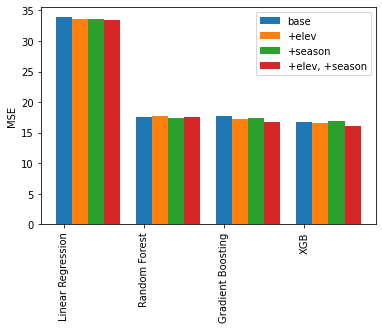

In [20]:
mse_wout_elev=[33.86869309419888, 17.52538845081093, 17.743511141294324, 16.69652236267537]
mse_w_elev=[33.675107088848016, 17.670795094414864, 17.292306306870085, 16.60130868490898]
mse_w_season=[33.598125657656894, 17.35979936070823, 17.33278814595927, 16.92945522241214]
mse_w_season_elevation=[33.402009465500335, 17.562966660433535, 16.80661088312985, 16.16207618241757]


n_bars=4
width = 1/(n_bars + 1)

fig, ax = plt.subplots(1)

for i, data in enumerate([mse_wout_elev, mse_w_elev, mse_w_season, mse_w_season_elevation]):
    ax.bar(
        x=np.arange(4) + i * width,
        height=data,
        width=width
    )

ax.set_xticks(np.arange(4))
ax.set_xticklabels(["Linear Regression", "Random Forest", "Gradient Boosting", "XGB"], rotation=90)
ax.legend(labels=["base", "+elev", "+season", "+elev, +season"])
ax.set_ylabel("MSE")
print()

# Q4. Why does the model perform better with seasonal data?
### We would expect the reanalysis data to capture all the information necessary regardless of the time (kind of stationary assumption?) but apparently, seasonal information does help the models perform better. Why is that?

In [9]:
attributes = LABELS + ["season_wet", "season_dry", "data_in"]

In [10]:
df_combined = pd.concat([df_train, df_valid, df_test]).reset_index().drop(labels=["index"], axis=1)
df_combined = df_combined[attributes]

<AxesSubplot:>

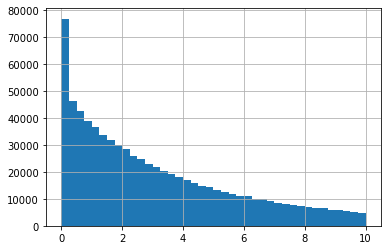

In [11]:
df_combined[df_combined['data_in'] < 10]['data_in'].hist(bins=40)

<AxesSubplot:>

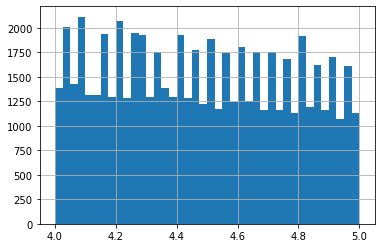

In [12]:
df_low = df_combined[(df_combined['data_in']<5) & (df_combined['data_in'] > 4)]
df_low['data_in'].hist(bins=40)

<AxesSubplot:>

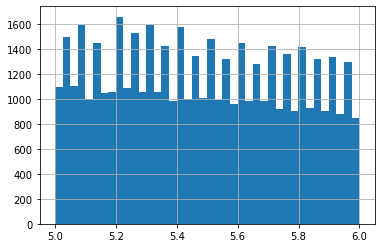

In [13]:
df_med = df_combined[(df_combined['data_in']<6) & (df_combined['data_in'] > 5)]
df_med['data_in'].hist(bins=40)

<AxesSubplot:>

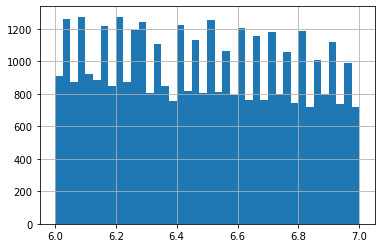

In [14]:
df_high = df_combined[(df_combined['data_in']<7) & (df_combined['data_in'] > 6)]
df_high['data_in'].hist(bins=40)

Text(0.5, 1.0, 'dry')

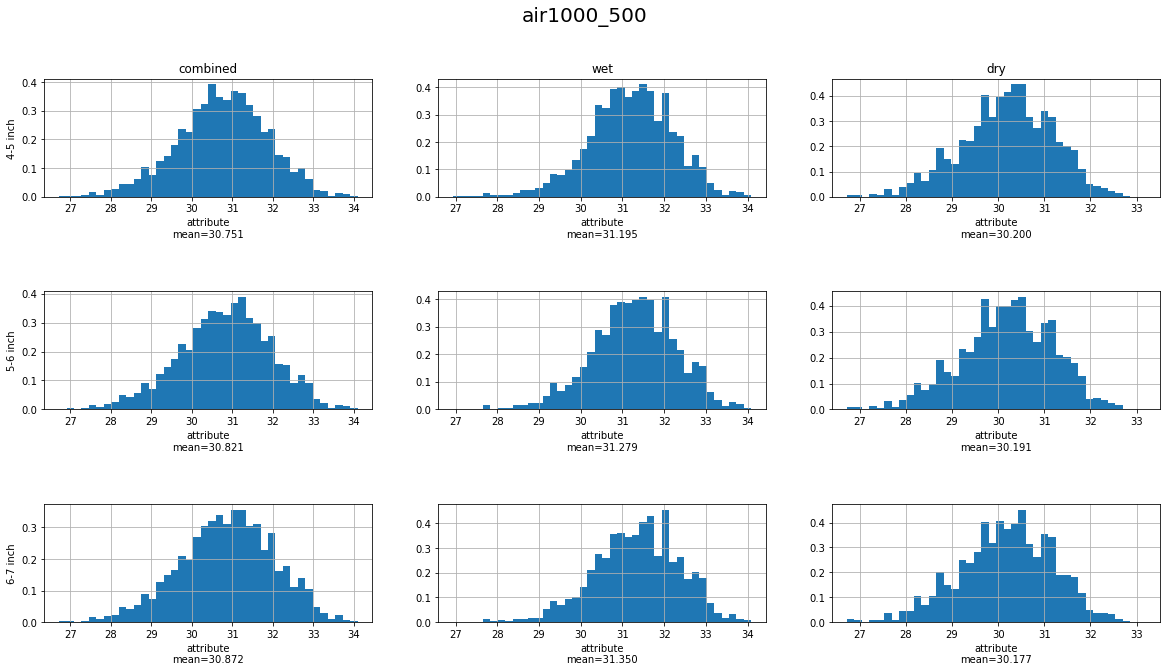

In [20]:
fig, axs = plt.subplots(3,3, figsize=(20,10),
                        #subplot_kw={'xlim': [90,200], 'ylim':[0, 0.05]},
                        gridspec_kw=dict(hspace=0.8, wspace=0.2)
                       )
attribute = LABELS[1]
fig.suptitle(attribute, fontsize=20)

for i, df in enumerate([df_low, df_med, df_high]):
    df[attribute].hist(ax=axs[i,0], bins=40, density=1)
    df[df['season_wet']==1][attribute].hist(ax=axs[i,1], bins=40, density=1)
    df[df['season_wet']==0][attribute].hist(ax=axs[i,2], bins=40, density=1)
    axs[i, 0].set_xlabel("attribute\nmean={:.3f}".format(df[attribute].mean()))
    axs[i, 1].set_xlabel("attribute\nmean={:.3f}".format(df[df['season_wet']==1][attribute].mean()))
    axs[i, 2].set_xlabel("attribute\nmean={:.3f}".format(df[df['season_wet']==0][attribute].mean()))


axs[0, 0].set_ylabel("4-5 inch")
axs[1, 0].set_ylabel("5-6 inch")
axs[2, 0].set_ylabel("6-7 inch")

axs[0, 0].set_title("combined")
axs[0, 1].set_title("wet")
axs[0, 2].set_title("dry")

# Q5. How does the performance change if we smooth out the observation of reanalysis data?
We can smooth out the observation using linear interpolation. For this, 5x5 grid of observations around hawaii was used to make the resolution higher.

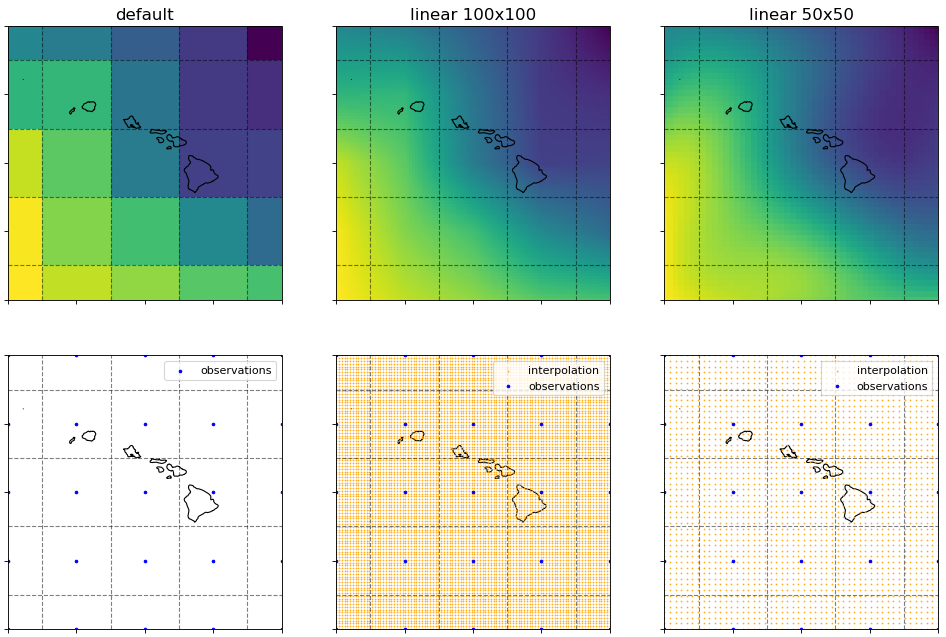

In [154]:
lat_hawaii = [15, 17.5, 20, 22.5, 25]
lon_hawaii = [-162.5, -160, -157.5, -155, -152.5]

# load a sample dataset
ds_air2m = xr.open_dataset(f"{BASE_DIR}/air.2m.mon.mean.regridded.nc")
data_matrix = ds_air2m.loc[dict(time="1948-06-01", lon=np.array(lon_hawaii) + 360, lat=lat_hawaii)]["air"]

# apply linear interpolation
data_matrix_interp_100 = data_matrix.interp(
    lat=np.linspace(lat_hawaii[0],
                    lat_hawaii[-1],
                    100
                   ),
    lon=np.linspace(lon_hawaii[0],
                    lon_hawaii[-1],
                    100
    ) + 360,
    method="linear"
)

data_matrix_interp_50 = data_matrix.interp(
    lat=np.linspace(lat_hawaii[0],
                    lat_hawaii[-1],
                    50
                   ),
    lon=np.linspace(lon_hawaii[0],
                    lon_hawaii[-1],
                    50
    ) + 360,
    method="cubic"
)

fig, axs = plt.subplots(
    2, 3, figsize=(15, 10), dpi=80,
    subplot_kw={'projection': ccrs.PlateCarree()},
)

xmin, xmax = -162.5, -152.5
ymin, ymax = 15, 25

data_matrix.plot(ax=axs[0, 0], add_colorbar=False)
data_matrix_interp_100.plot(ax=axs[0, 1], add_colorbar=False)
data_matrix_interp_50.plot(ax=axs[0, 2], add_colorbar=False)

for ax in axs.flatten():
    ax.set_xticks(np.arange(xmin, xmax+1, 2.5))
    ax.set_yticks(np.arange(ymin, ymax+1, 2.5))
    ax.set_ylabel("")

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.coastlines(resolution='10m')
    ax.grid(linewidth=2, color='black', linestyle='--')
    ax.vlines(x=np.arange(xmin, xmax+1, 2.5) - 1.25, ymin=ymin, ymax=ymax, color="k", linewidth=1, linestyle="--", alpha=0.5)
    ax.hlines(y=np.arange(ymin, ymax+1, 2.5) - 1.25 , xmin=xmin, xmax=xmax, color="k", linewidth=1, linestyle="--", alpha=0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel("")
axs[0, 0].set_title("default", fontsize=(15))
axs[0, 1].set_title("linear 100x100", fontsize=(15))
axs[0, 2].set_title("linear 50x50", fontsize=(15))


# lower plots
xx, yy = np.meshgrid(lon_hawaii, lat_hawaii)

xx_interp_50, yy_interp_50 = np.meshgrid(
    np.linspace(lon_hawaii[0], lon_hawaii[-1], 50),
    np.linspace(lat_hawaii[0], lat_hawaii[-1], 50)
)

xx_interp_100, yy_interp_100 = np.meshgrid(
    np.linspace(lon_hawaii[0], lon_hawaii[-1], 100),
    np.linspace(lat_hawaii[0], lat_hawaii[-1], 100)
)

interpolation = axs[1, 1].scatter(xx_interp_100, yy_interp_100, s=0.3, label="interpolation", color='orange')
interpolation = axs[1, 2].scatter(xx_interp_50, yy_interp_50, s=0.3, label="interpolation", color='orange')

for i in range(3):
    observations = axs[1, i].scatter(xx, yy, s=5, label="observations", color='blue')
    axs[1, i].legend(loc=1)

print()

## Q3.1 Linear Interpolation with lower resolution

In [23]:
columns = [
    'data_in',
    'lat', 'lon', 'elevation', 'season_wet', 'season_dry',
    'i50_air2m', 'i50_air1000_500', 'i50_hgt500', 'i50_hgt1000', 'i50_omega500',
    'i50_pottemp1000-500', 'i50_pottemp1000-850', 'i50_pr_wtr', 'i50_shum-uwnd-700',
    'i50_shum-uwnd-925', 'i50_shum-vwnd-700', 'i50_shum-vwnd-950', 'i50_shum700', 'i50_shum925', 
    'i50_skt', 'i50_slp'
]

In [24]:
Xtrain = np.array(df_train[columns].drop(labels=["data_in"], axis=1))
Ytrain = np.array(df_train["data_in"])

Xvalid = np.array(df_valid[columns].drop(labels=["data_in"], axis=1))
Yvalid = np.array(df_valid["data_in"])

Xtest = np.array(df_test[columns].drop(labels=["data_in"], axis=1))
Ytest = np.array(df_test["data_in"])

In [25]:
# hyperparameters acquired in external experiment: fine tuned
linear_regression = LinearRegression()
random_forest = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=3,
    n_jobs=-1,
    verbose=False,
)

gradient_boost = GradientBoostingRegressor(
    n_estimators=170, 
    learning_rate=0.1,
    max_depth=7,
    min_samples_split=6,
    verbose=False
)

xgboost = XGBRegressor(
    n_estimators=210, # 160?
    learning_rate=0.1,
    max_depth=9,
    verbosity=0
)

linear_regression.fit(Xtrain, Ytrain)
random_forest.fit(Xtrain, Ytrain)
gradient_boost.fit(Xtrain, Ytrain)
xgboost.fit(Xtrain, Ytrain)

mse_interp_50 = [
    mean_squared_error(Ytest, linear_regression.predict(Xtest)),
    mean_squared_error(Ytest, random_forest.predict(Xtest)),
    mean_squared_error(Ytest, gradient_boost.predict(Xtest)),
    mean_squared_error(Ytest, xgboost.predict(Xtest)),
]
print(f"{mse_interp_50=}")

mse_interp_50=[36.22769920327844, 19.740148378466692, 17.95918604163002, 17.284053261648335]


## Q3.2 Linear Interpolation with higher resolution

In [3]:
columns = [
    'data_in',
    'lat', 'lon', 'elevation', 'season_wet', 'season_dry',
    'i100_air2m', 'i100_air1000_500', 'i100_hgt500', 'i100_hgt1000', 'i100_omega500',
    'i100_pottemp1000-500', 'i100_pottemp1000-850', 'i100_pr_wtr', 'i100_shum-uwnd-700',
    'i100_shum-uwnd-925', 'i100_shum-vwnd-700', 'i100_shum-vwnd-950', 'i100_shum700', 'i100_shum925', 
    'i100_skt', 'i100_slp'
]

In [4]:
Xtrain = np.array(df_train[columns].drop(labels=["data_in"], axis=1))
Ytrain = np.array(df_train["data_in"])

Xvalid = np.array(df_valid[columns].drop(labels=["data_in"], axis=1))
Yvalid = np.array(df_valid["data_in"])

Xtest = np.array(df_test[columns].drop(labels=["data_in"], axis=1))
Ytest = np.array(df_test["data_in"])

In [8]:
# hyperparameters acquired in external experiment: fine tuned
linear_regression = LinearRegression()
random_forest = RandomForestRegressor(
    n_estimators=210,
    max_depth=None,
    min_samples_split=5,
    n_jobs=-1,
    verbose=False,
)

gradient_boost = GradientBoostingRegressor(
    n_estimators=240, 
    learning_rate=0.1,
    max_depth=7,
    min_samples_split=2,
    verbose=False
)

xgboost = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=9,
    verbosity=0
)

linear_regression.fit(Xtrain, Ytrain)
random_forest.fit(Xtrain, Ytrain)
gradient_boost.fit(Xtrain, Ytrain)
xgboost.fit(Xtrain, Ytrain)

mse_interp_50 = [
    mean_squared_error(Ytest, linear_regression.predict(Xtest)),
    mean_squared_error(Ytest, random_forest.predict(Xtest)),
    mean_squared_error(Ytest, gradient_boost.predict(Xtest)),
    mean_squared_error(Ytest, xgboost.predict(Xtest)),
]

print(f"{mse_interp_50=}")

mse_interp_50=[36.22769920327844, 19.913305540134004, 17.923331294777736, 17.284053261648335]


# Q4. How does the performance change if we feed more reanalysis data from neighboring 6 grids?

In [3]:
reanalysis_data = [
    'air2m', 'air1000_500', 'hgt500', 'hgt1000', 'omega500',
    'pottemp1000-500', 'pottemp1000-850', 'pr_wtr', 'shum-uwnd-700',
    'shum-uwnd-925', 'shum-vwnd-700', 'shum-vwnd-950', 'shum700', 'shum925', 
    'skt', 'slp'
]

columns = []
for i in range(6):
    for item in reanalysis_data:
        columns.append(f"{item}_{i}")

columns.extend(['data_in', 'lat', 'lon', 'elevation', 'season_wet', 'season_dry'])
for item in columns:
    print(item, end=' ')

air2m_0 air1000_500_0 hgt500_0 hgt1000_0 omega500_0 pottemp1000-500_0 pottemp1000-850_0 pr_wtr_0 shum-uwnd-700_0 shum-uwnd-925_0 shum-vwnd-700_0 shum-vwnd-950_0 shum700_0 shum925_0 skt_0 slp_0 air2m_1 air1000_500_1 hgt500_1 hgt1000_1 omega500_1 pottemp1000-500_1 pottemp1000-850_1 pr_wtr_1 shum-uwnd-700_1 shum-uwnd-925_1 shum-vwnd-700_1 shum-vwnd-950_1 shum700_1 shum925_1 skt_1 slp_1 air2m_2 air1000_500_2 hgt500_2 hgt1000_2 omega500_2 pottemp1000-500_2 pottemp1000-850_2 pr_wtr_2 shum-uwnd-700_2 shum-uwnd-925_2 shum-vwnd-700_2 shum-vwnd-950_2 shum700_2 shum925_2 skt_2 slp_2 air2m_3 air1000_500_3 hgt500_3 hgt1000_3 omega500_3 pottemp1000-500_3 pottemp1000-850_3 pr_wtr_3 shum-uwnd-700_3 shum-uwnd-925_3 shum-vwnd-700_3 shum-vwnd-950_3 shum700_3 shum925_3 skt_3 slp_3 air2m_4 air1000_500_4 hgt500_4 hgt1000_4 omega500_4 pottemp1000-500_4 pottemp1000-850_4 pr_wtr_4 shum-uwnd-700_4 shum-uwnd-925_4 shum-vwnd-700_4 shum-vwnd-950_4 shum700_4 shum925_4 skt_4 slp_4 air2m_5 air1000_500_5 hgt500_5 hgt1

In [4]:
Xtrain = np.array(df_train[columns].drop(labels=["data_in"], axis=1))
Ytrain = np.array(df_train["data_in"])

Xvalid = np.array(df_valid[columns].drop(labels=["data_in"], axis=1))
Yvalid = np.array(df_valid["data_in"])

Xtest = np.array(df_test[columns].drop(labels=["data_in"], axis=1))
Ytest = np.array(df_test["data_in"])

In [6]:
# hyperparameters obtained by fine tuning
params = {
    "n_estimators": 220, #(150, 200)
    "max_depth": None, #(None)
    "min_samples_split": 2,
    "n_jobs": -1,
    "verbose" : False
}

random_forest = RandomForestRegressor(**params)
random_forest.fit(Xtrain, Ytrain)
print("MSE on random forest: {:.3f}".format(mean_squared_error(Ytest, random_forest.predict(Xtest))))
print("MSE on random forest: {:.3f}".format(mean_squared_error(Ytrain, random_forest.predict(Xtrain))))

MSE on random forest: 17.963
MSE on random forest: 0.783


In [ ]:
gradient_boost = GradientBoostingRegressor(
    n_estimators=300, 
    learning_rate=0.1,
    max_depth=6,
    min_samples_split=2,
    verbose=False
)

gradient_boost.fit(Xtrain, Ytrain)
print("MSE on gradient boost (test) : {:.3f}".format(mean_squared_error(Ytest, gradient_boost.predict(Xtest))))
print("MSE on gradient boost (train): {:.3f}".format(mean_squared_error(Ytrain, gradient_boost.predict(Xtrain))))

In [6]:
# hyperparameters obtained by fine tuning
xgboost = XGBRegressor(
    n_estimators=170,
    learning_rate=0.1,
    max_depth=9,
    verbosity=0
)

xgboost.fit(Xtrain, Ytrain)
print("MSE on xgboost (test) : {:.5f}".format(mean_squared_error(Ytest, xgboost.predict(Xtest))))
print("MSE on xgboost (train): {:.5f}".format(mean_squared_error(Ytrain, xgboost.predict(Xtrain))))

MSE on xgboost (test) : 15.80659
MSE on xgboost (train): 4.65344


# Prediction comparison

In [189]:
df_metadata = pd.read_excel(f"{BASE_DIR}/FilledDataset2012.xlsx", sheet_name="Header")
df_test = df_metadata[["Lat_DD", "Lon_DD"]].drop_duplicates().rename({"Lat_DD": "lat", "Lon_DD": "lon"}, axis=1)
df_test["rainfall"] = df_test.apply(lambda x: np.random.normal(loc=10), axis=1)



In [190]:
df_test

,lat,lon,rainfall
0,18.916176,-155.674994,12.145990
1,18.913680,-155.680550,7.661871
2,18.938669,-155.680549,10.808190
3,19.108660,-155.825545,10.091865
4,19.108890,-155.746670,11.085384
...,...,...,...
2219,22.202190,-159.347203,10.661517
2220,22.186077,-159.318870,11.037714
2221,22.182760,-159.332203,10.756760
2222,22.183333,-159.337500,9.549867


In [197]:
df_test.set_index(["lat", "lon"]).to_xarray()['rainfall']

<xarray.DataArray 'rainfall' (lat: 2212, lon: 2213)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 18.91 18.92 18.94 18.94 ... 22.22 22.22 22.23 22.23
  * lon      (lon) float64 -159.8 -159.8 -159.8 -159.8 ... -154.8 -154.8 -154.8

In [188]:
xr_rainfall = df_test.set_index(["lat", "lon"]).to_xarray().to_array()

,lat,lon,rainfall
0,18.916176,-155.674994,8.317383
1,18.913680,-155.680550,9.069875
2,18.938669,-155.680549,10.037701
3,19.108660,-155.825545,10.591811
4,19.108890,-155.746670,10.130340
...,...,...,...
2219,22.202190,-159.347203,7.985933
2220,22.186077,-159.318870,10.662709
2221,22.182760,-159.332203,9.725834
2222,22.183333,-159.337500,9.765372


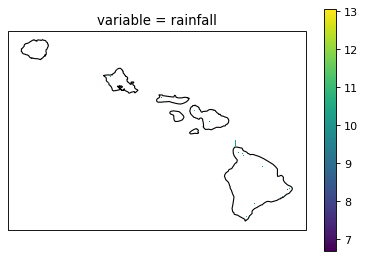

In [204]:
fig, ax = plt.subplots(1, dpi=80, subplot_kw={'projection': ccrs.PlateCarree()},)
ax.coastlines(resolution='10m')
xr_rainfall.plot(ax=ax)

In [170]:
type(xr_rainfall)

xarray.core.dataarray.DataArray

In [21]:
lat = df_metadata["Lat_DD"]
lon = df_metadata["Lon_DD"]
rainfall = np.random.normal(size=df_metadata.shape[0])

xr.DataArray(
    data=rainfall,
    dims=["lat", "lon"],
    coords=dict(
        lat=(["x", "y"], lat),
        lon=(["x", "y"], lon)
    )
)

ValueError: different number of dimensions on data and dims: 1 vs 2

In [2]:
Xtrain = np.array(df_train[BEST_MODEL_COLUMNS].drop(labels=["data_in"], axis=1))
Ytrain = np.array(df_train["data_in"])

Xvalid = np.array(df_valid[BEST_MODEL_COLUMNS].drop(labels=["data_in"], axis=1))
Yvalid = np.array(df_valid["data_in"])

Xtest = np.array(df_test[BEST_MODEL_COLUMNS].drop(labels=["data_in"], axis=1))
Ytest = np.array(df_test["data_in"])

NameError: name 'df_train' is not defined

In [8]:
# hyperparameters obtained by fine tuning
xgboost = XGBRegressor(
    n_estimators=170,
    learning_rate=0.1,
    max_depth=9,
    verbosity=0
)

xgboost.fit(Xtrain, Ytrain)
print("MSE on xgboost (test) : {:.5f}".format(mean_squared_error(Ytest, xgboost.predict(Xtest))))
print("MSE on xgboost (train): {:.5f}".format(mean_squared_error(Ytrain, xgboost.predict(Xtrain))))

MSE on xgboost (test) : 15.80659
MSE on xgboost (train): 4.65344


In [9]:
df_metadata = pd.read_excel(f"{BASE_DIR}/FilledDataset2012.xlsx", sheet_name="Header")

In [12]:
df_metadata

,SKN,Name,Lat_DD,Lon_DD,ElevFT,Observer,Status2010,NumMos,MinYear,MaxYear
0,1.0,KALAE,18.916176,-155.674994,35.000000,USCG,Discontinued,277,1924,1949
1,1.1,MORSE FIELD,18.913680,-155.680550,40.000000,US AIR FORCE,Discontinued,33,1939,1941
2,1.2,KALAE S TRK STA,18.938669,-155.680549,305.000000,SPACE TECH LAB,Discontinued,55,1965,1969
3,2.0,MANUKA,19.108660,-155.825545,1750.000000,STATE DIV OF FTRY,Current,514,1952,2013
4,2.1,KAHUKU MAUKA 2.10,19.108890,-155.746670,3150.784336,NCDC_Daily,Discontinued,32,2007,2009
...,...,...,...,...,...,...,...,...,...,...
2219,1143.0,FIELD 30,22.202190,-159.347203,230.000000,KILAUEA SUGAR,Discontinued,392,1937,1970
2220,1144.0,FIELD 7-A,22.186077,-159.318870,200.000000,LIHUE PLANTATION,Discontinued,292,1936,1968
2221,1145.0,PUU AUAU,22.182760,-159.332203,330.000000,LIHUE PLANTATION,Current,838,1926,2013
2222,1146.0,Moloaa Dairy,22.183333,-159.337500,280.000000,RAWS,Current,95,2002,2012


In [13]:
df_metadata[["ElevFT", "Lat_DD", "Lon_DD"]]

,ElevFT,Lat_DD,Lon_DD
0,35.000000,18.916176,-155.674994
1,40.000000,18.913680,-155.680550
2,305.000000,18.938669,-155.680549
3,1750.000000,19.108660,-155.825545
4,3150.784336,19.108890,-155.746670
...,...,...,...
2219,230.000000,22.202190,-159.347203
2220,200.000000,22.186077,-159.318870
2221,330.000000,22.182760,-159.332203
2222,280.000000,22.183333,-159.337500


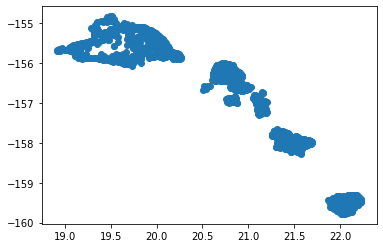

In [18]:
fig, ax = plt.subplots()
ax.scatter(x=df_metadata['Lat_DD'], y=df_metadata["Lon_DD"])
# ax.set_aspect("equal")

In [ ]:
# make sure the purity of dataset: data split has to be based on month
# hyperparameter tuning on all of the models

# To make comparison to Kristene's model, Randomly choose months to make prediction on, 
# train multi-linear regression and random forest and report the result